In [1]:
import pandas as pd
import numpy as np


events = pd.read_csv('events.csv')
ginf= pd.read_csv('ginf.csv')
total_data = pd.merge(events, ginf, how='right', on = 'id_odsp')
total_data = total_data[total_data['adv_stats']]
total_data = total_data[np.isfinite(total_data['time'])]
total_data['home_score'] =0
total_data['away_score'] =0
total_data['home_score'] = np.where((total_data.is_goal == 1) & (total_data['ht'] == total_data.event_team), 1, 0)
total_data['away_score'] = np.where((total_data.is_goal == 1) & (total_data['at'] == total_data.event_team), 1, 0)
total_data['Home_win'] = np.where((total_data.fthg > total_data.ftag),1, 0)
total_data['Away_win'] = np.where((total_data.ftag > total_data.fthg),1, 0)
total_data['Draw_win'] = np.where((total_data.ftag == total_data.fthg),1, 0)
############## handling each features individually #################
winFeatures =['id_odsp','time','home_score','away_score']
winDf= total_data[winFeatures].drop_duplicates()
winDf = winDf.loc[(winDf.home_score != 0) | (winDf.away_score != 0) ]
oddsFeatures = ['id_odsp','odd_a','odd_h']
oddsDf= total_data[oddsFeatures].drop_duplicates()
overallwinFeatures = ['id_odsp','Home_win','Away_win']
overall_win= total_data[overallwinFeatures].drop_duplicates()
####################################################################

#############Common time and id df#################################
one_to_hundred = pd.Series(range(0,101,1))
game_time_series = pd.concat([one_to_hundred]*9074, ignore_index=True)
game_unique_ids = total_data.id_odsp.unique()
game_unique_idseries = np.repeat(game_unique_ids, 101)

####################################################################
################      Merging Data     #############################
Actual_dataI = pd.DataFrame({'time' : game_time_series, 'id_odsp' : game_unique_idseries})
Actual_dataI = pd.merge(Actual_dataI, winDf, how='left', on=['time','id_odsp'] )
Actual_dataI = Actual_dataI.fillna(0)
Actual_dataI = pd.merge(Actual_dataI, oddsDf, how='left', on=['id_odsp'] )
Actual_dataI = pd.merge(Actual_dataI, overall_win, how='left', on=['id_odsp'] )
groupedItem = Actual_dataI.groupby('id_odsp')
Actual_dataI['Home_score_cum'] = groupedItem.home_score.cumsum()
Actual_dataI['Away_score_cum'] = groupedItem.away_score.cumsum()
Actual_dataI['goal_diff'] =  np.where((Actual_dataI['odd_h'] < Actual_dataI['odd_a']), Actual_dataI['Home_score_cum'] - Actual_dataI['Away_score_cum'], 
                                          Actual_dataI['Away_score_cum'] - Actual_dataI['Home_score_cum'])

In [2]:
##Remove Tied teams
GameData = Actual_dataI.loc[(Actual_dataI['Home_win'] != Actual_dataI['Away_win'])]
#tied team data 
TiedData = Actual_dataI.loc[(Actual_dataI['Home_win'] == Actual_dataI['Away_win'])]

In [8]:
import math
from sklearn import preprocessing

def checkInterval(goaldiff, time):
    ret = 0
    if time >= 0 and time <=25:
        ret=  1.008
    elif time > 25 and time <=45:
        ret= 1.0008
    elif time > 45 and time <=75:
        ret= 1.0003
    elif time > 75 and time <=85:
        ret= 1.0004
    elif time > 85 and time <=90:
        ret= 1.0008
    elif time > 90 and time <=95:
        ret= 1.0008
    elif time >95 and time <= 100:
        ret= 1.0009
    if goaldiff >= 0:
        return 1/ret
    elif goaldiff < 0:
        return ret
    
previous_goal_diff = 0
previous_prob = 0
favourable_A = 0
favourable_B = 0
ExpA =0
ExpB =0

def findK(r,p,v):
    ret =0
    if r <= 1:
        ret = 1
    elif r ==2:
        ret = 2
    elif r >=3:
        ret = (r + 11)/8
    if ((v ==1) & (p < 0)) | ((v ==2) & (p > 0)) :
        ret = ret * -1
    return 60 * ret

def CurrentResult(r, v):
    return 2
        
def findExpected(x, y):
    return 1/(1 + 10**(((-1 * (100+ x - y))/400)))

def findProbability(r):
    global favourable_A 
    global favourable_B
    global previous_goal_diff 
    global ExpA
    global ExpB
    if(r['time'] == 0):
        previous_goal_diff =0
        if r['odd_h'] < r['odd_a']:
            favourable_A = 1/r['odd_h']
            favourable_B = 1/r['odd_a'] 
        else :
            favourable_A = 1/r['odd_a']
            favourable_B = 1/r['odd_h']
        favourable_A = 400 + (favourable_A * 100)
        favourable_B = 400 + (favourable_B * 100)
        ExpA = findExpected(favourable_A, favourable_B)
        ExpB = (1 - ExpA)
    else:
        if ((r['home_score'] == 1) or (r['away_score'] == 1)):
            favourable_A = favourable_A + (findK(r['goal_diff'],r['goal_diff']- previous_goal_diff ,1)*(CurrentResult(r['goal_diff'], 1) - ExpA))
            favourable_B = favourable_B + (findK(r['goal_diff'],r['goal_diff']- previous_goal_diff,2)*(CurrentResult(r['goal_diff'],2) - ExpB))
            ExpA = findExpected(favourable_A, favourable_B)
        ExpA = (ExpA)**(checkInterval(r['goal_diff'],r['time']))
        ExpB = (1 - ExpA)    
    previous_goal_diff = r['goal_diff']   
    return ExpA   

In [9]:
GameData_copy =GameData.copy()
GameData_copy['prob'] = GameData_copy.apply(lambda row : findProbability(row), axis=1)

In [16]:
## Evaluation 
prob_count= [ 0 for i in range(0,11)]
total_count= [ 0 for i in range(0,11)]
percentage= [ 0 for i in range(0,11)]
counter = 0.0
for i in range(0,11):
    p1 = GameData_copy.loc[(round (GameData_copy['prob'],1) == round(counter,1)) & 
                                      (GameData_copy['odd_h'] < GameData_copy['odd_a']) & 
                                      (GameData_copy['Home_win'] == 1)].shape[0]
    p2 = GameData_copy.loc[(round (GameData_copy['prob'],1) == round(counter,1)) & 
                                      (GameData_copy['odd_a'] < GameData_copy['odd_h']) & 
                                      (GameData_copy['Away_win'] == 1)].shape[0]
    total_count[i] = GameData_copy.loc[(round (GameData_copy['prob'],1) == round(counter,1))].shape[0]
    prob_count[i] = p1+p2
    counter = round(counter,1)+0.1
for i in range(0,11):
    if total_count[i] == 0:
        total_count[i] = 1    
    percentage[i] = (prob_count[i]/total_count[i]) * 100

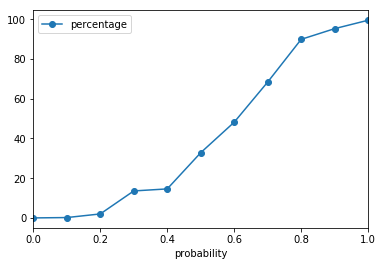

In [17]:
##Plot graph###
import matplotlib.pyplot as plt
p = [i*0.1 for i in range(0,11)]
ev_df = pd.DataFrame(
    {'percentage': percentage,
    'probability': p
    })
ev_df.plot(x= 'probability', y= 'percentage',style='-o')
plt.show()

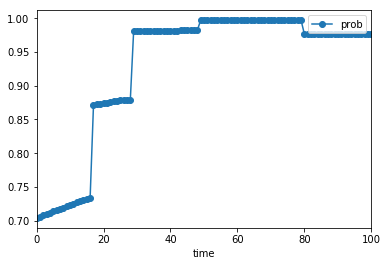

In [18]:
import matplotlib.pyplot as plt
GameData_copy.iloc[0:101,:].plot(x= 'time', y= 'prob',style='-o')
plt.show()

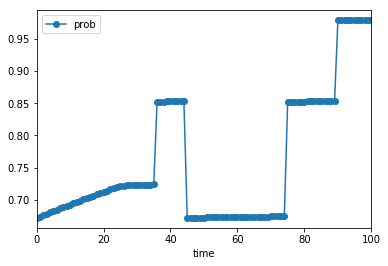

In [21]:
GameData_copy.iloc[808:909,:].plot(x= 'time', y= 'prob',style='-o')
plt.show()